# Install libs

In [19]:
!pip install numpy pandas matplotlib seaborn torch torchvision trimesh tqdm timm -q

# Import libs

In [32]:
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from tqdm.notebook import tqdm
import random

# For 3D data
import trimesh

# For image data
from PIL import Image

# For PyTorch
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim


# Glabal variables and preferences

In [33]:
random_state = 69

DATA_ROOT = Path("data/")
TRAIN_ROOT = DATA_ROOT / "train_data"
IMG_DIR = TRAIN_ROOT / "images"
STL_DIR = TRAIN_ROOT / "models"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

IMG_SIZE = (224, 224)
NUM_SAMPLE_POINTS = 2048
BATCH_SIZE = 32

EMBEDDING_DIM = 512

LEARNING_RATE_IMAGE = 1e-5 # Lower LR for pretrained image encoder
LEARNING_RATE_PC = 1e-4    # Higher LR for point cloud encoder
MARGIN = 0.2
NUM_EPOCHS = 10 # Adjust based on dataset size and convergence

Using device: cuda


# Download Data
The download may take 5-7 minutes.

In [11]:
import requests
import zipfile
import os
from urllib.parse import urlencode


def download_and_unzip_yandex_disk(public_url, extract_to_folder):
    """
    Downloads and unzips a file from Yandex.Disk using a public link.

    :param public_url: Public URL to the file on Yandex.Disk.
    :param extract_to_folder: The folder where the archive will be extracted.
    """
    print(f"Starting to process link: {public_url}")

    # 1. Get the direct download link from the Yandex.Disk API
    base_api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download?"
    api_url = base_api_url + urlencode(dict(public_key=public_url))

    try:
        response = requests.get(api_url)
        response.raise_for_status()  # Check for HTTP errors
        download_url = response.json().get("href")

        if not download_url:
            print(f"Error: Could not get a direct download link for {public_url}")
            return

        print("Direct download link obtained.")

        # 2. Download the file
        print("Downloading file...")
        download_response = requests.get(download_url)
        download_response.raise_for_status()

        # Temporary name for the zip file
        zip_filename = "temp_download.zip"

        with open(zip_filename, "wb") as f:
            f.write(download_response.content)
        print(f"File '{zip_filename}' downloaded successfully.")

        # 3. Unzip the archive
        print(f"Unzipping archive to folder '{extract_to_folder}'...")
        if not os.path.exists(extract_to_folder):
            os.makedirs(extract_to_folder)

        with zipfile.ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(extract_to_folder)
        print(f"Files successfully unzipped to '{extract_to_folder}'.")

        # 4. Remove the downloaded zip archive
        os.remove(zip_filename)
        print(f"Temporary file '{zip_filename}' has been removed.")

    except requests.exceptions.RequestException as e:
        print(f"A network or API error occurred: {e}")
        print("Tip: Make sure your environment can access 'cloud-api.yandex.net'.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# --- MAIN SCRIPT ---
# Define the files to be downloaded
files_to_download = {
    "train": {
        "url": "https://disk.yandex.ru/d/RRXJu9ZtEmSXzQ",  # Use the standard share link
        "folder": DATA_ROOT,
    },
    "test": {
        "url": "https://disk.yandex.ru/d/TmbB7BsGzg1dQQ",  # Use the standard share link
        "folder": DATA_ROOT,
    },
}

# Start the process for each file
for key, data in files_to_download.items():
    download_and_unzip_yandex_disk(data["url"], data["folder"])
    print("-" * 20)

print("\nAll operations completed!")

Starting to process link: https://disk.yandex.ru/d/RRXJu9ZtEmSXzQ
Direct download link obtained.
File 'temp_download.zip' downloaded successfully.
Unzipping archive to folder 'data'...
Files successfully unzipped to 'data'.
Temporary file 'temp_download.zip' has been removed.
--------------------
Starting to process link: https://disk.yandex.ru/d/TmbB7BsGzg1dQQ
Direct download link obtained.
File 'temp_download.zip' downloaded successfully.
Unzipping archive to folder 'data'...
Files successfully unzipped to 'data'.
Temporary file 'temp_download.zip' has been removed.
--------------------

All operations completed!


# Define data classes

In [ ]:
class CADModel:
    """
    A wrapper class for a 3D CAD model loaded from an STL file.
    Provides easy access to mesh properties and common operations.
    """

    def __init__(self, file_path: str | Path):
        self.file_path = Path(file_path)
        if not self.file_path.exists():
            raise FileNotFoundError(f"File not found: {self.file_path}")

        # Load the mesh using trimesh
        # process=False prevents trimesh from merging vertices, which can be slow
        self.mesh = trimesh.load(self.file_path, process=False)

    @property
    def vertices(self):
        # Get the vertices of the mesh
        return self.mesh.vertices

    @property
    def faces(self):
        # Get the faces (triangles) of the mesh
        return self.mesh.faces

    @property
    def num_vertices(self):
        # Get the total number of vertices
        return len(self.vertices)

    @property
    def extents(self):
        return self.mesh.extents

    @property
    def is_watertight(self):
        return self.is_watertight

    def get_properties(self) -> dict:
        """Returns basic properties of the mesh."""
        if self.mesh is None:
            return {}
        return {
            "vertices": len(self.mesh.vertices),
            "faces": len(self.mesh.faces),
            "is_watertight": self.mesh.is_watertight,
            "extents": self.mesh.extents,  # The size of the bounding box
        }

    def sample_points(self, num_points: int = 2048) -> np.ndarray:
        """
        Samples a fixed number of points from the mesh surface.
        This is a common way to represent a mesh for deep learning models.
        """
        # The returned points will have shape (num_points, 3)
        return self.mesh.sample(num_points)

    def normalize(self):
        """
        Normalizes the mesh to fit within a unit sphere.
        This is a crucial preprocessing step for most 3D deep learning models.
        """
        # Center the mesh at the origin
        center = self.mesh.bounds.mean(axis=0)
        self.mesh.apply_translation(-center)

        # Scale the mesh to fit in a unit sphere
        scale = np.max(np.linalg.norm(self.mesh.vertices, axis=1))
        self.mesh.apply_scale(1 / scale)

    def __repr__(self):
        return f"CADModel(file='{self.file_path.name}', vertices={self.num_vertices})"


class ImageSTLPairDataset(Dataset):
    """
    PyTorch Dataset to serve pairs of (image, point_cloud).
    """

    def __init__(
        self,
        image_dir: str | Path,
        model_dir: str | Path,
        num_points: int = NUM_SAMPLE_POINTS,
        image_transform=None,
        point_cloud_transform=None,
    ):
        self.image_dir = Path(image_dir)
        self.model_dir = Path(model_dir)
        self.num_points = num_points
        self.image_transform = image_transform
        self.point_cloud_transform = point_cloud_transform

        self.image_paths = sorted(list(self.image_dir.glob("*.png")))

    def __len__(self):
        # The total size of the dataset is the number of images
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        # Get the image path
        image_path = self.image_paths[idx]

        # Load and transform the image
        image = Image.open(image_path).convert("RGB")
        if self.image_transform:
            image = self.image_transform(image)

        # Get the corresponding model path
        model_id = image_path.name.split("_")[0]
        model_path = self.model_dir / f"{model_id}.stl"

        # Load, normalize, and sample the 3D model
        model = CADModel(model_path)
        model.normalize()  # Crucial preprocessing step
        point_cloud = model.sample_points(self.num_points)

        # Convert point cloud to tensor
        point_cloud = torch.tensor(point_cloud, dtype=torch.float32)

        if self.point_cloud_transform:
            point_cloud = self.point_cloud_transform(point_cloud)

        return image, point_cloud

# --- Define transforms ---
# Standard transforms for models pre-trained on ImageNet
image_transforms = T.Compose(
    [
        T.Resize(IMG_SIZE),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# --- Create Dataset and DataLoader ---
try:
    train_dataset = ImageSTLPairDataset(
        image_dir=IMG_DIR,
        model_dir=STL_DIR,
        num_points=NUM_SAMPLE_POINTS,  # A common choice for point cloud models
        image_transform=image_transforms,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
        shuffle=True,
        num_workers=2,  # Use multiple workers to speed up data loading
    )

    # --- Test the DataLoader ---
    print(f"Dataset size: {len(train_dataset)}")
    images, point_clouds = next(iter(train_loader))
    print(f"Image batch shape: {images.shape}")
    print(f"Point cloud batch shape: {point_clouds.shape}")

except NameError:
    print("Skipping DataLoader test as data paths are not fully defined.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure your data paths (DATA_ROOT, etc.) are correct.")

Dataset size: 13650
Image batch shape: torch.Size([32, 3, 224, 224])
Point cloud batch shape: torch.Size([32, 2048, 3])


In [27]:
class InferenceDataset(Dataset):
    """
    PyTorch Dataset for loading items for inference (queries or gallery).
    Loads either images or meshes from a given directory.
    """
    def __init__(self, data_path: Path, modality: str, num_points: int = NUM_SAMPLE_POINTS, image_transform=None):
        """
        Args:
            data_path (Path): Path to the directory with data files.
            modality (str): The type of data to load, 'image' or 'mesh'.
            num_points (int): Number of points to sample from each mesh.
            image_transform (callable, optional): Transform for images.
        """
        self.data_path = data_path
        self.modality = modality
        self.num_points = num_points
        self.image_transform = image_transform

        if self.modality == 'image':
            self.files = sorted(list(self.data_path.glob("*.png")))
        elif self.modality == 'mesh':
            self.files = sorted(list(self.data_path.glob("*.stl")))
        else:
            raise ValueError("Modality must be 'image' or 'mesh'")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        item_id = file_path.stem # e.g., 'q0001' or 'g0012'

        if self.modality == 'image':
            item = Image.open(file_path).convert("RGB")
            if self.image_transform:
                item = self.image_transform(item)
        else: # modality == 'mesh'
            cad_object = CADObject(file_path)
            points = cad_object.sample_points(self.num_points)
            item = torch.from_numpy(points).float()
            
        return item_id, item

# --- Example Usage ---
# Use the same image transforms as for training
# Let's assume the test data is in 'data/test_data'
TEST_PATH = DATA_ROOT / "test_data"

# Create a dataset for image queries
# (This is a hypothetical example, assuming the folder exists)
if (TEST_PATH / "queries_image_to_mesh").exists():
    image_query_dataset = InferenceDataset(
        data_path=TEST_PATH / "queries_image_to_mesh",
        modality='image',
        image_transform=image_transforms
    )
    
    # Check one item
    item_id, item_tensor = image_query_dataset[0]
    print("\n--- Inference Dataset Check ---")
    print(f"Modality: 'image'")
    print(f"Item ID: {item_id}")
    print(f"Item tensor shape: {item_tensor.shape}")
else:
    print("\n--- Inference Dataset Check ---")
    print("Test data directory not found, skipping example usage.")



--- Inference Dataset Check ---
Modality: 'image'
Item ID: q0000
Item tensor shape: torch.Size([3, 224, 224])


## Analize data

Found 525 STL files.
Found 13650 image files.


Analyzing STL files:   0%|          | 0/525 [00:00<?, ?it/s]

Analyzing Images:   0%|          | 0/13650 [00:00<?, ?it/s]

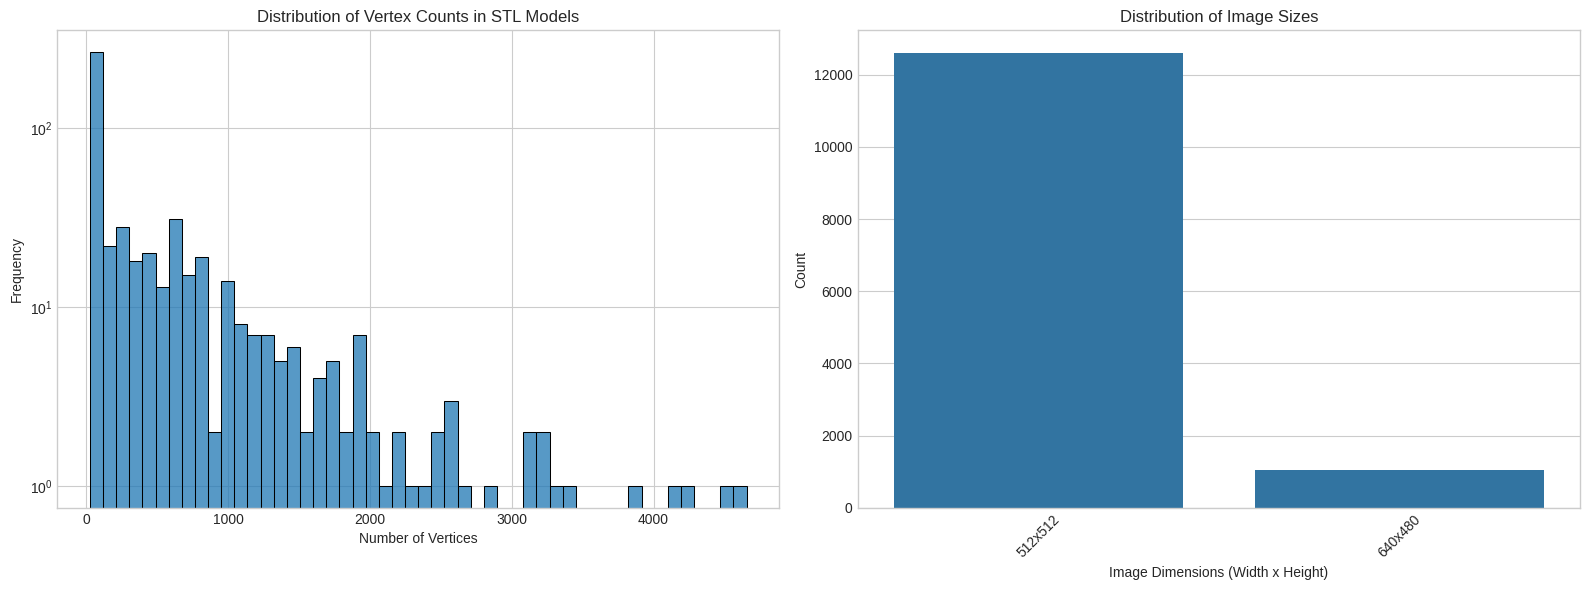


STL Model Statistics:
count     525.000000
mean      495.285714
std       735.653447
min        24.000000
25%        36.000000
50%       108.000000
75%       660.000000
max      4656.000000
Name: vertex_count, dtype: float64

Image Size Statistics:
size_str
512x512    12600
640x480     1050
Name: count, dtype: int64


In [ ]:
# --- Data Collection ---
stl_files = list(STL_DIR.glob("*.stl"))
img_files = list(IMG_DIR.glob("*.png"))

print(f"Found {len(stl_files)} STL files.")
print(f"Found {len(img_files)} image files.")

# --- Analyze STL files ---
vertex_counts = []
for stl_path in tqdm(stl_files, desc="Analyzing STL files"):
    try:
        model = CADModel(stl_path)
        vertex_counts.append(model.num_vertices)
    except Exception as e:
        print(f"Could not load {stl_path.name}: {e}")

# --- Analyze Image files ---
image_sizes = []
for img_path in tqdm(img_files, desc="Analyzing Images"):
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)
    except Exception as e:
        print(f"Could not load {img_path.name}: {e}")

# --- Create DataFrame for analysis ---
eda_df = pd.DataFrame({"vertex_count": vertex_counts})
img_df = pd.DataFrame(image_sizes, columns=["width", "height"])


# --- Visualization ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot vertex count distribution
sns.histplot(data=eda_df, x="vertex_count", bins=50, ax=axes[0])
axes[0].set_title("Distribution of Vertex Counts in STL Models")
axes[0].set_xlabel("Number of Vertices")
axes[0].set_ylabel("Frequency")
axes[0].set_yscale("log")  # Use log scale for better visibility

# Plot image size distribution
img_df["size_str"] = img_df.apply(lambda row: f"{row['width']}x{row['height']}", axis=1)
sns.countplot(data=img_df, x="size_str", ax=axes[1])
axes[1].set_title("Distribution of Image Sizes")
axes[1].set_xlabel("Image Dimensions (Width x Height)")
axes[1].set_ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# --- Print Summary Statistics ---
print("\nSTL Model Statistics:")
print(eda_df["vertex_count"].describe())

print("\nImage Size Statistics:")
print(img_df["size_str"].value_counts())


--- Sample Point Cloud Visualization ---


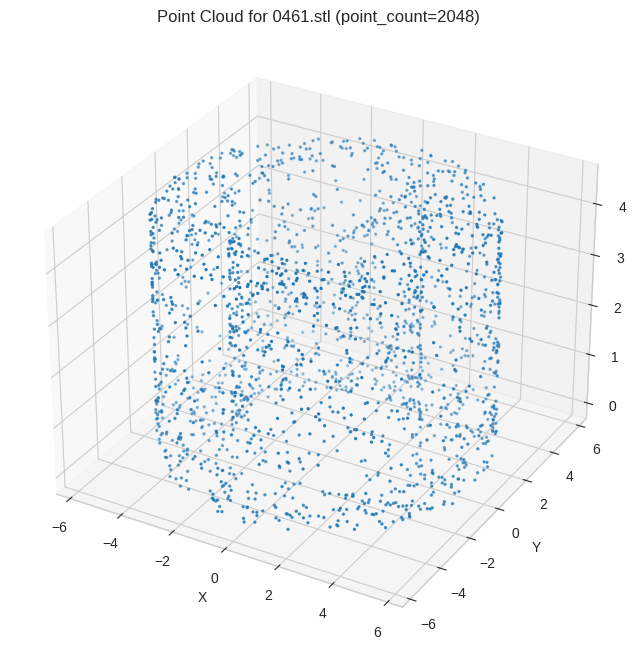

In [ ]:
# Visualize a sample model's point cloud
print("\n--- Sample Point Cloud Visualization ---")
sample_model = CADModel(random.choice(stl_files))
if sample_model.mesh:
    point_count = NUM_SAMPLE_POINTS
    points = sample_model.sample_points(point_count)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=2)
    ax.set_title(f"Point Cloud for {stl_files[0].name} ({point_count=})")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# Models
## Image encoder model EfficientNet-B0

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encodes images into a fixed-size embedding vector.
    Uses a pretrained backbone and a projection head.
    """

    def __init__(
        self,
        model_name: str = "efficientnet_b0",
        pretrained: bool = True,
        embedding_dim: int = EMBEDDING_DIM,
    ):
        """
        Args:
            model_name (str): Name of the model from 'timm' library.
            pretrained (bool): Whether to use pretrained weights.
            embedding_dim (int): The dimension of the final output embedding.
        """
        super().__init__()
        # Load the pretrained backbone
        self.backbone = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0
        )  # num_classes=0 removes the classifier

        # Get the feature dimension from the backbone
        in_features = self.backbone.num_features

        # Create the projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features, in_features // 2),
            nn.ReLU(),
            nn.Linear(in_features // 2, embedding_dim),
        )

    def forward(self, x):
        """
        Forward pass to get image embeddings.

        Args:
            x (torch.Tensor): Batch of images, shape (N, 3, H, W).

        Returns:
            torch.Tensor: Batch of embeddings, shape (N, embedding_dim).
        """
        features = self.backbone(x)
        embedding = self.projection(features)
        return embedding


# --- Test the ImageEncoder ---
device = "cuda" if torch.cuda.is_available() else "cpu"
image_encoder = ImageEncoder(embedding_dim=EMBEDDING_DIM).to(device)

# Create a dummy batch of images
dummy_images = torch.randn(4, 3, 224, 224).to(device)  # Batch size of 4

# Get embeddings
with torch.no_grad():
    image_embeddings = image_encoder(dummy_images)

print("--- Image Encoder Check ---")
print(f"Image encoder output shape: {image_embeddings.shape}")  # Expected: [4, EMBEDDING_DIM]

--- Image Encoder Check ---
Image encoder output shape: torch.Size([4, 512])


## 3D Encoder model PointNet-like

In [ ]:
class PointCloudEncoder(nn.Module):
    """
    Encodes point clouds into a fixed-size embedding vector.
    Inspired by the PointNet architecture.
    """
    def __init__(self, num_points: int = NUM_SAMPLE_POINTS, embedding_dim: int = EMBEDDING_DIM):
        """
        Args:
            num_points (int): The number of points in the input point cloud.
            embedding_dim (int): The dimension of the final output embedding.
        """
        super().__init__()
        self.num_points = num_points
        
        # Feature learning layers
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 512, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(512)
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, x):
        """
        Forward pass to get point cloud embeddings.
        
        Args:
            x (torch.Tensor): Batch of point clouds, shape (N, num_points, 3).
            
        Returns:
            torch.Tensor: Batch of embeddings, shape (N, embedding_dim).
        """
        # PointNet expects (N, D, P), where D is dimensions (3) and P is num_points
        x = x.permute(0, 2, 1)
        
        # Pass through feature learning layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Global feature aggregation using max pooling
        # x shape is (N, 512, num_points)
        global_feature = torch.max(x, 2, keepdim=True)[0] # (N, 512, 1)
        global_feature = global_feature.view(-1, 512)   # (N, 512)
        
        # Get final embedding
        embedding = self.projection(global_feature)
        return embedding

# --- Test the PointCloudEncoder ---
pc_encoder = PointCloudEncoder(num_points=NUM_SAMPLE_POINTS, embedding_dim=EMBEDDING_DIM).to(device)

# Create a dummy batch of point clouds
dummy_pcs = torch.randn(4, 2048, 3).to(device) # Batch size of 4

# Get embeddings
with torch.no_grad():
    pc_embeddings = pc_encoder(dummy_pcs)

print("\n--- Point Cloud Encoder Check ---")
print(f"Point cloud encoder output shape: {pc_embeddings.shape}") # Expected: [4, EMBEDDING_DIM]


--- Point Cloud Encoder Check ---
Point cloud encoder output shape: torch.Size([4, 512])


## Train models.
Loss: Triplet loss

In [28]:
class TripletLoss(nn.Module):
    """
    Calculates the Triplet Loss for multimodal embeddings.
    """
    def __init__(self, margin: float = 0.2):
        super().__init__()
        self.margin = margin
        self.loss_fn = nn.TripletMarginLoss(margin=margin, p=2) # p=2 for Euclidean distance

    def forward(self, anchor_embeddings, positive_embeddings, negative_embeddings):
        """
        Args:
            anchor_embeddings (torch.Tensor): Embeddings of the anchor modality.
            positive_embeddings (torch.Tensor): Embeddings of the positive modality (matching the anchor).
            negative_embeddings (torch.Tensor): Embeddings of the negative modality (mismatching the anchor).
        """
        loss = self.loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)
        return loss

In [ ]:
# Initialize models
image_encoder = ImageEncoder(embedding_dim=EMBEDDING_DIM).to(device)
pc_encoder = PointCloudEncoder(num_points=NUM_SAMPLE_POINTS, embedding_dim=EMBEDDING_DIM).to(device)

# Define the loss function
criterion = TripletLoss(margin=MARGIN)

# Define optimizers with different learning rates
# We use AdamW, which is generally robust and effective
optimizer = optim.AdamW([
    {'params': image_encoder.parameters(), 'lr': LEARNING_RATE_IMAGE},
    {'params': pc_encoder.parameters(), 'lr': LEARNING_RATE_PC}
])

# Setup DataLoader (assuming train_dataloader was defined in Cell 4)
# If not, run Cell 4 again
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("Training setup complete.")

Training setup complete.


In [35]:
def train_epoch(image_encoder, pc_encoder, dataloader, criterion, optimizer, device):
    image_encoder.train()
    pc_encoder.train()
    
    total_loss = 0
    
    # We use tqdm for a nice progress bar
    for images, point_clouds in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        point_clouds = point_clouds.to(device)
        
        optimizer.zero_grad()
        
        # 1. Generate embeddings for the batch
        image_embeddings = image_encoder(images)
        pc_embeddings = pc_encoder(point_clouds)
        
        # 2. Calculate Triplet Loss using In-Batch Negatives
        # For a batch of size N, we have N pairs of (Image_i, PC_i).
        # We want to minimize distance(Image_i, PC_i) (Positive)
        # and maximize distance(Image_i, PC_j) where i != j (Negative)
        
        # We can calculate the loss in both directions: Image->PC and PC->Image
        
        # Loss 1: Image as Anchor, PC as Positive
        # We use the PC embeddings of the current batch as potential negatives
        loss_image_to_pc = criterion(image_embeddings, pc_embeddings, pc_embeddings)
        
        # Loss 2: PC as Anchor, Image as Positive
        # We use the Image embeddings of the current batch as potential negatives
        loss_pc_to_image = criterion(pc_embeddings, image_embeddings, image_embeddings)
        
        # Total loss is the sum of both directions
        loss = loss_image_to_pc + loss_pc_to_image
        
        # 3. Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    return avg_loss

# --- Start Training ---
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    avg_loss = train_epoch(image_encoder, pc_encoder, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Average Loss: {avg_loss:.4f}")

# Save the models
torch.save(image_encoder.state_dict(), 'image_encoder.pth')
torch.save(pc_encoder.state_dict(), 'pc_encoder.pth')
print("Training finished and models saved.")

Starting training...


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 1/10, Average Loss: 0.4000


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 2/10, Average Loss: 0.4000


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 3/10, Average Loss: 0.4000


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 4/10, Average Loss: 0.4000


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 5/10, Average Loss: 0.4000


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 6/10, Average Loss: 0.4000


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 7/10, Average Loss: 0.4000


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 8/10, Average Loss: 0.4000


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 9/10, Average Loss: 0.4000


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Epoch 10/10, Average Loss: 0.4000
Training finished and models saved.


# Load models and inference

In [39]:
image_encoder = ImageEncoder(embedding_dim=EMBEDDING_DIM).to(device)
pc_encoder = PointCloudEncoder(num_points=NUM_SAMPLE_POINTS, embedding_dim=EMBEDDING_DIM).to(device)

# --- Load saved weights ---
try:
    image_encoder.load_state_dict(torch.load('image_encoder.pth', map_location=device))
    pc_encoder.load_state_dict(torch.load('pc_encoder.pth', map_location=device))
    print("Successfully loaded trained models.")
except FileNotFoundError:
    print("Model weights not found. Please ensure training was completed and files are in the correct path.")
    # You might want to stop execution here if models are essential for the next steps
    # For now, we'll continue, but subsequent cells will fail.

# --- Set models to evaluation mode ---
image_encoder.eval()
pc_encoder.eval()
print()

Successfully loaded trained models.



In [40]:
def generate_embeddings(model, dataloader, device):
    """
    Generates embeddings for all items in a dataloader.
    
    Args:
        model (nn.Module): The encoder model to use.
        dataloader (DataLoader): DataLoader for the inference dataset.
        device (str): The device to run inference on ('cuda' or 'cpu').
        
    Returns:
        tuple: A tuple containing:
            - dict: A dictionary mapping item_id to its embedding.
            - list: A list of all item_ids in order.
            - np.ndarray: A numpy array of all embeddings, stacked.
    """
    embeddings_dict = {}
    all_embeddings = []
    all_ids = []
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for ids, items in tqdm(dataloader, desc="Generating embeddings"):
            items = items.to(device)
            embeddings = model(items)
            
            # Move embeddings to CPU and convert to numpy
            embeddings_np = embeddings.cpu().numpy()
            
            for i, item_id in enumerate(ids):
                embeddings_dict[item_id] = embeddings_np[i]
                all_ids.append(item_id)
                all_embeddings.append(embeddings_np[i])

    return embeddings_dict, all_ids, np.vstack(all_embeddings)